In [40]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

from pathlib import Path

import sys

sys.path.append(str(Path.home() / "Projects" / "MRI" / "MaxEnt"))

import Basic_functions as bf
import Synthetic_data as sd
import R_roughness as rr

importlib.reload(bf)
importlib.reload(sd)
importlib.reload(rr)

import D1_cube_with_noise_with_roughness_normalize as dcwwn

importlib.reload(dcwwn)

<module 'D1_cube_with_noise_with_roughness_normalize' from '/Users/xunan/Projects/MRI/MaxEnt/D1_cube_with_noise_with_roughness_normalize.py'>

### Synthetic data

In [59]:
np.random.seed(0)

qs = np.linspace(0, 3.5, 3).reshape((-1, 1), order = 'C')

thetas = np.linspace(0, 2, 1000)

voxels = 1

_, f_true = sd.synthetic_f_line_1D(thetas, voxels = voxels, normalize = True)

thetas, weights = dcwwn.Cartesian(thetas)
qs, Sqs_noisefree = sd.synthetic_Sqs_line_1D(qs, thetas, f_true, sigma=0)

SNR = 1e4

sigma = np.sqrt(np.mean(Sqs_noisefree**2) / SNR); print("Noise sigma:", sigma)

Sqs_noisy = Sqs_noisefree + np.random.normal(scale = sigma, size = (Sqs_noisefree.shape[0], Sqs_noisefree.shape[1]))

R = np.zeros((len(qs), len(qs)))



Noise sigma: 0.005923798486734634


In [60]:
lambdas_star, f_hat_star, obj_history = dcwwn.Newton_Armijo(  qs, thetas, weights, Sqs_noisy, sigma = sigma, R = R, f0 = None, normalize = False,
                                                Lambdas = None,
                                                ridge = False, log_max = -2, log_min = -4, n_last = 10, 
                                                use_cg = False, pc_method = 'jacobi', cg_rtol = 1e-8, cg_maxiter = 1000, 
                                                beta=0.5, c=1e-4, tol=1e-10, epsilon = 1e-10, max_iter=500)

### Real samples of $\lambda^*$, by generating a lot of pieces of noisy signal data

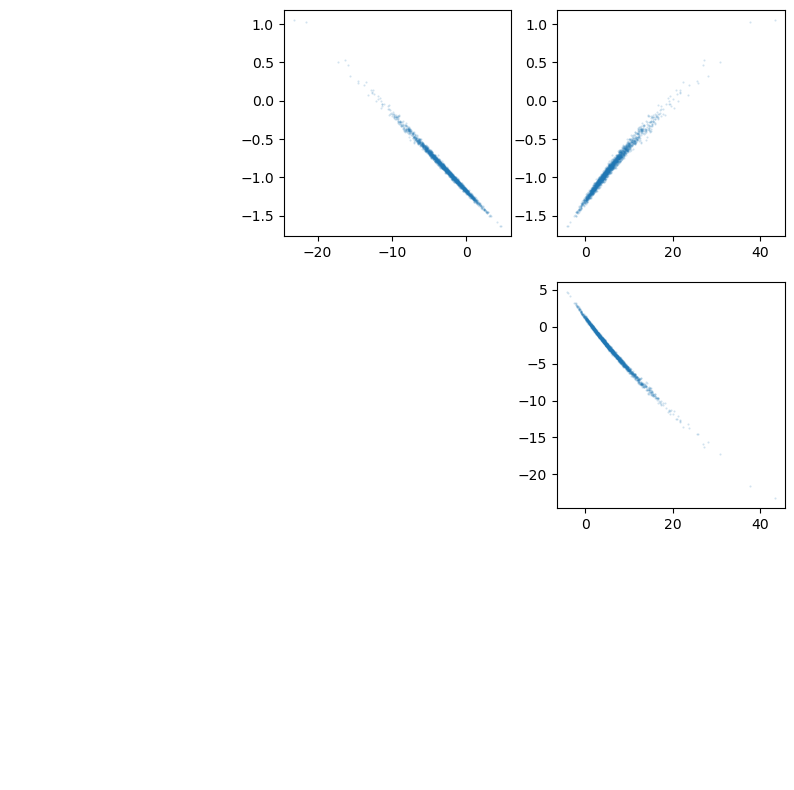

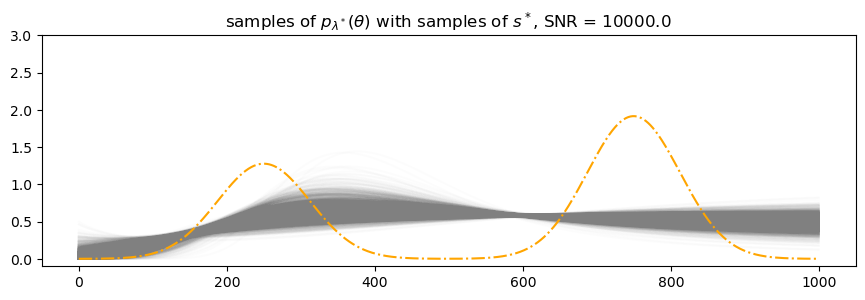

In [61]:
run = 2000

lambdas_sample = np.empty((run, len(qs)))
f_sample = np.empty((run, len(thetas)))

for i in range(run):
    Sqs_noisy_sample = Sqs_noisefree + np.random.normal(scale = sigma, size = (Sqs_noisefree.shape[0], Sqs_noisefree.shape[1]))
    lambdas_hat_sample, f_hat_sample, _ = dcwwn.Newton_Armijo(  qs, thetas, weights, Sqs_noisy_sample, sigma = sigma, R = R, f0 = None, normalize = False,
                                                Lambdas = None,
                                                ridge = False, log_max = -2, log_min = -4, n_last = 10, 
                                                use_cg = False, pc_method = 'jacobi', cg_rtol = 1e-8, cg_maxiter = 1000, 
                                                beta=0.5, c=1e-4, tol=1e-10, epsilon = 1e-10, max_iter=500)
    lambdas_sample[i, :] = lambdas_hat_sample
    f_hat_sample = f_hat_sample / (f_hat_sample @ weights)
    f_sample[i,:] = f_hat_sample

fig, axes = plt.subplots(len(qs), len(qs), figsize=(10, 10))  # n×n grid

for i in range(len(qs)):
    for j in range(len(qs)):
        ax = axes[i, j]
        if j > i:
            ax.plot(lambdas_sample[:, j], lambdas_sample[:, i], '.', markersize = 1, alpha=0.2)
        else:
            ax.axis('off')  # blank lower triangle for clarity
# plt.plot(lambdas_sample[:, 0], lambdas_sample[:, 2], '.', alpha = 0.2)
# plt.axis('equal')

plt.figure(figsize=(10.5, 3))
plt.plot(f_sample.T, '-', color = 'gray', alpha = 0.02)
plt.plot(f_true.ravel(), '-.', color = 'orange', label = 'True')
plt.ylim(-0.1, 3)
# plt.legend()
plt.title(rf'samples of $p_{{\lambda^*}}(\theta)$ with samples of $s^*$, SNR = {SNR}')
plt.show()

(array([  1.,   0.,   5.,   6.,  21.,  23.,  52.,  79.,  95.,  95., 141.,
         95., 111., 101.,  61.,  49.,  38.,  14.,   6.,   7.]),
 array([-125.1708505 , -113.55740469, -101.94395887,  -90.33051306,
         -78.71706724,  -67.10362143,  -55.49017561,  -43.8767298 ,
         -32.26328398,  -20.64983817,   -9.03639235,    2.57705346,
          14.19049927,   25.80394509,   37.4173909 ,   49.03083672,
          60.64428253,   72.25772835,   83.87117416,   95.48461998,
         107.09806579]),
 <BarContainer object of 20 artists>)

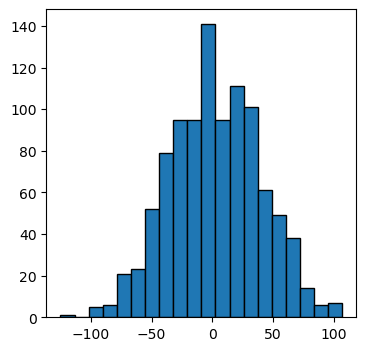

In [31]:
plt.figure(figsize=(4, 4))
plt.hist(lambdas_sample[:, 0], bins = 20, edgecolor = 'black')

In [32]:
from sklearn.linear_model import LinearRegression

X = lambdas_sample[:, 0].reshape(-1, 1)  # scikit-learn needs 2D features
y = lambdas_sample[:, 1]

model = LinearRegression().fit(X, y)
print("Slope:", model.coef_[0], "Intercept:", model.intercept_)

Slope: -3.710011771492024 Intercept: -8.309167491282606


## Taylor expansion

In [62]:

run = 1000

lambdas_sample_first = np.empty((run, len(qs)))
lambdas_sample_second = np.empty((run, len(qs)))
lambdas_sample_third = np.empty((run, len(qs)))

f_sample_first  = np.empty((run, len(thetas))) # store Taylor expansion samples of 1st order 
f_sample_second = np.empty((run, len(thetas))) # store Taylor expansion samples of 2nd order 
f_sample_third  = np.empty((run, len(thetas))) # store Taylor expansion samples of 3rd order 

pre_mat, fir_der, sec_der, thi_der = dcwwn.uncertainty(lambdas_star, qs, thetas, weights, Sqs_noisy_sample, sigma, R, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False)

for i in range(run):
    sample = np.random.normal(scale = sigma, size = (Sqs_noisefree.shape[0], Sqs_noisefree.shape[1])).ravel()

    delta_first  = sample @ fir_der
    delta_second = delta_first + np.einsum('i,ijk,k->j', sample, sec_der, sample) / 2  
    delta_third  = delta_second + np.einsum('ijkl,i,k,l->j', thi_der, sample, sample, sample) / 6

    x_first  = lambdas_star + delta_first
    x_second = lambdas_star + delta_second
    x_third  = lambdas_star + delta_third

    lambdas_sample_first[i, :] = x_first
    lambdas_sample_second[i, :] = x_second
    lambdas_sample_third[i, :] = x_third

    f_sample_first [i,:] = dcwwn.f_thetas_hat(x_first,  qs, thetas, weights, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False).ravel()
    f_sample_second[i,:] = dcwwn.f_thetas_hat(x_second, qs, thetas, weights, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False).ravel()
    f_sample_third [i,:] = dcwwn.f_thetas_hat(x_third,  qs, thetas, weights, 1/np.sum(weights)*np.ones((1, len(thetas))), normalize = False).ravel()

In [34]:
eigvals, eigvecs = np.linalg.eig(pre_mat)
print(eigvals)

[2.10239921e+05 1.05980457e+03 8.00668924e-01 4.46654533e-04
 2.05887481e-05 1.91310701e-05 1.91224541e-05 1.91224191e-05
 1.91224209e-05 1.91224222e-05]


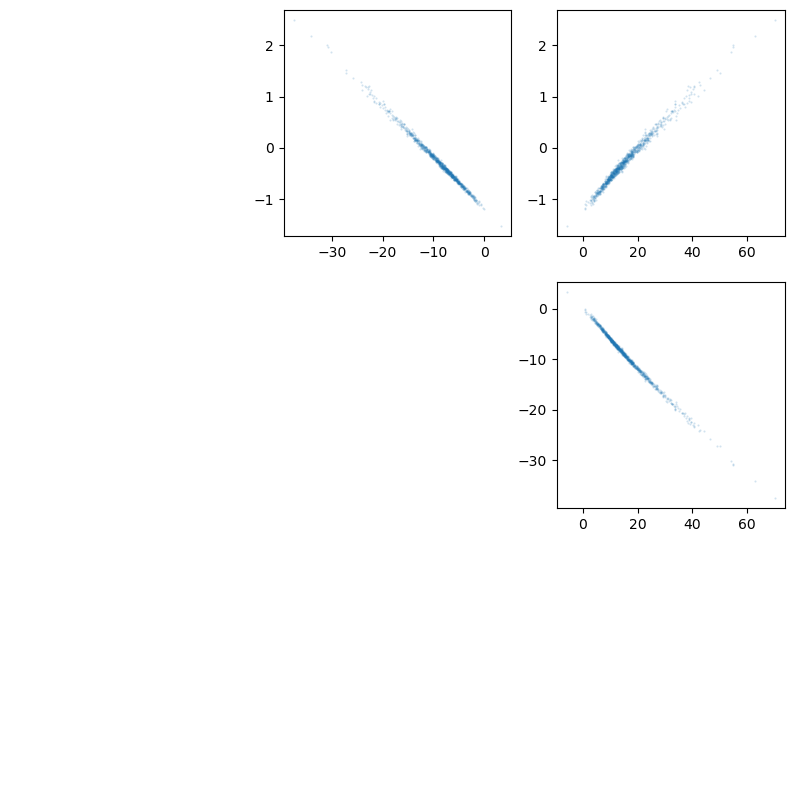

In [65]:
fig, axes = plt.subplots(len(qs), len(qs), figsize=(10, 10))  # n×n grid

for i in range(len(qs)):
    for j in range(len(qs)):
        ax = axes[i, j]
        if j > i:
            ax.plot(lambdas_sample_third[:, j], lambdas_sample_third[:, i], '.', markersize = 1, alpha=0.2)
        else:
            ax.axis('off')  # blank lower triangle for clarity

In [53]:
X = lambdas_sample_first[:, 0].reshape(-1, 1)  # scikit-learn needs 2D features
y = lambdas_sample_first[:, 1]

model = LinearRegression().fit(X, y)
print("Slope:", model.coef_[0], "Intercept:", model.intercept_)

Slope: -9.920870755982442 Intercept: -11.66623203257982


1st order

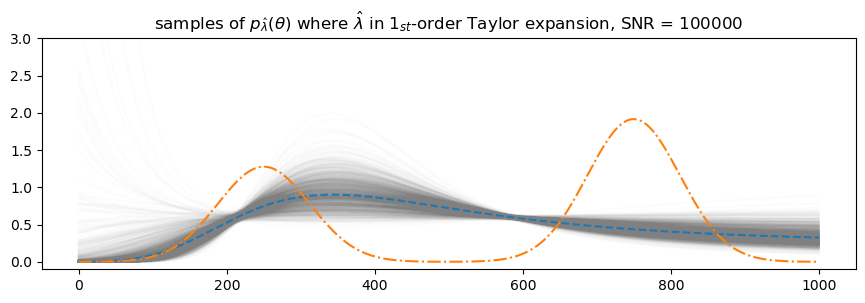

In [41]:
plt.figure(figsize=(10.5, 3))
plt.plot(f_sample_first.T, '-', color = 'gray', alpha = 0.02)
plt.plot(f_hat_star.T, '--', label = 'Mean')
plt.plot(f_true.ravel(), '-.', label = 'True')
plt.ylim(-0.1, 3)
# plt.legend()
plt.title(r'samples of $p_{\hat{\lambda}}(\theta)$ where $\hat{\lambda}$ in $1_{st}$-order Taylor expansion, SNR = 100000')
plt.show()

2nd

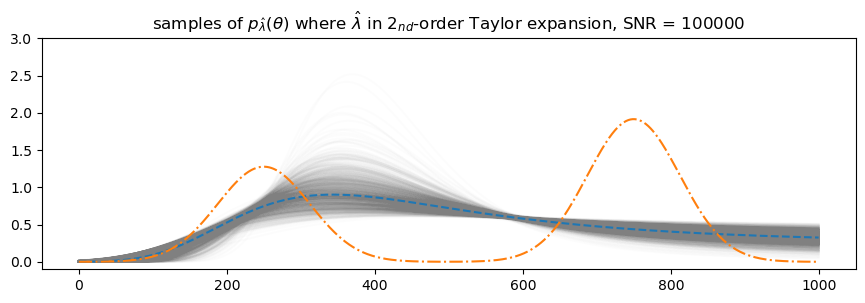

In [42]:
plt.figure(figsize=(10.5, 3))
plt.plot(f_sample_second.T, '-', color = 'gray', alpha = 0.02)
plt.plot(f_hat_star.T, '--', label = 'Mean')
plt.plot(f_true.ravel(), '-.', label = 'True')
plt.ylim(-0.1, 3)
# plt.legend()
plt.title(r'samples of $p_{\hat{\lambda}}(\theta)$ where $\hat{\lambda}$ in $2_{nd}$-order Taylor expansion, SNR = 100000')
plt.show()

3rd

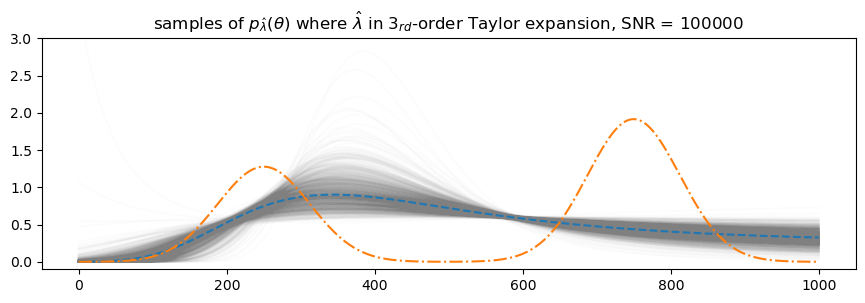

In [43]:
plt.figure(figsize=(10.5, 3))
plt.plot(f_sample_third.T, '-', color = 'gray', alpha = 0.02)
plt.plot(f_hat_star.T, '--', label = 'Mean')
plt.plot(f_true.ravel(), '-.', label = 'True')
plt.ylim(-0.1, 3)
# plt.legend()
plt.title(r'samples of $p_{\hat{\lambda}}(\theta)$ where $\hat{\lambda}$ in $3_{rd}$-order Taylor expansion, SNR = 100000')
plt.show()

Slope: -9.852909367267022 Intercept: -11.594439625679513
